In [2]:
!pip install kaggle

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import string
from nltk.stem import PorterStemmer

In [4]:
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [5]:
!chmod 600 /content/kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle competitions download -c quora-question-pairs -f train.csv.zip
!kaggle competitions download -c quora-question-pairs -f test.csv.zip
!kaggle competitions download -c quora-question-pairs -f sample_submission.csv.zip

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip train.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [7]:
train_df = pd.read_csv('train.csv')
train_df = train_df.sample(30000,random_state=2)

In [8]:
train_df.shape

(30000, 6)

In [9]:
train_df.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


In [10]:
train_df.sample(3,random_state=3)

,id,qid1,qid2,question1,question2,is_duplicate
296049,296049,418195,50380,How much discount (on laptops) does Dell give ...,"Which laptop I should buy, Dell or Lenovo or HP ?",0
398596,398596,156431,21963,What is the weirdest website you have seen?,Which are the weirdest websites on the internet?,1
77607,77607,58656,132473,What is the best time of day for workout and e...,What is the best time to work out? Why?,1


<Axes: xlabel='is_duplicate'>

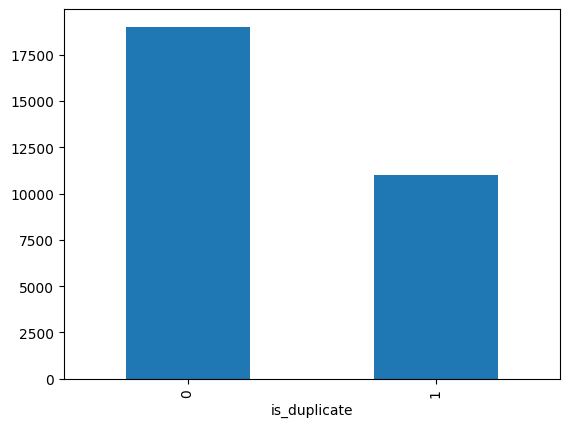

In [11]:
train_df['is_duplicate'].value_counts().plot(kind = 'bar')

In [12]:
no_1 = train_df[train_df['is_duplicate'] == 1].shape[0]
no_0 = train_df[train_df['is_duplicate'] == 0].shape[0]
print("non_duplicate: ",no_0/train_df['is_duplicate'].count())
print("duplicate: ",no_1/train_df['is_duplicate'].count())

non_duplicate:  0.6337666666666667
duplicate:  0.36623333333333336


In [13]:
qids = pd.Series(train_df['qid1'].tolist() + train_df['qid2'].tolist())
print("no of unique questions",qids.value_counts().shape[0])
x = qids.value_counts()>1
print("Repeated questions: ",x[x].shape[0])

no of unique questions 55299
Repeated questions:  3480


In [14]:
train_df.sample(3,random_state = 3)

,id,qid1,qid2,question1,question2,is_duplicate
296049,296049,418195,50380,How much discount (on laptops) does Dell give ...,"Which laptop I should buy, Dell or Lenovo or HP ?",0
398596,398596,156431,21963,What is the weirdest website you have seen?,Which are the weirdest websites on the internet?,1
77607,77607,58656,132473,What is the best time of day for workout and e...,What is the best time to work out? Why?,1


In [15]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
#whether html tags are present or not
is_presetn_html_q1 = [q for q in train_df['question1'] for w in q.split() if re.compile('<.*?>').search(w) ]
print("html tags in q1",len(is_presetn_html_q1))
is_presetn_html_q2 = [q for q in train_df['question2'] for w in q.split() if re.compile('<.*?>').search(w) ]
print("html tags in q2",len(is_presetn_html_q2))

html tags in q1 4
html tags in q2 4


In [17]:
from nltk import sent_tokenize,word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
#remove punctuation
#remove html tags
#tokenize
#remove urls
#lower casing
#remove stopwords
ps = PorterStemmer()
def text_preprocess(text):
  #lower casing
  text =  text.lower()
  #tokenize
  text = word_tokenize(text)

  new_text = []
  for i in text:
    if i.isalnum():
      new_text.append(i)

  text = new_text[:]
  new_text.clear()

  for word in text:
    if word not in stopwords.words('english') and word not in string.punctuation:
      new_text.append(word)

  text = new_text[:]
  new_text.clear()
  for word in text:
    new_text.append(ps.stem(word))

  return " ".join(new_text)

In [19]:
train_df['question1'] = train_df['question1'].apply(text_preprocess)
train_df['question2'] = train_df['question2'].apply(text_preprocess)

In [20]:
train_df.sample(3,random_state = 3)

,id,qid1,qid2,question1,question2,is_duplicate
296049,296049,418195,50380,much discount laptop dell give employe india p...,laptop buy dell lenovo hp,0
398596,398596,156431,21963,weirdest websit seen,weirdest websit internet,1
77607,77607,58656,132473,best time day workout exercis,best time work,1


In [21]:
# no of words in both q1 and q2
#no of character in both q1 and q2
#no of common words in both q1 and q2
# total no of words in a row
# common words/total no of words in a row

train_df['char_len_q1'] = train_df['question1'].str.len()
train_df['char_len_q2'] = train_df['question2'].str.len()

train_df['num_words_q1'] = train_df['question1'].apply(lambda x: len(x.split(" ")))
train_df['num_words_q2'] = train_df['question2'].apply(lambda x: len(x.split(" ")))

In [22]:

def common_words(row):
  q1_words = set(map(lambda x: x.lower().strip(),row['question1'].split(" ")))
  q2_words = set(map(lambda x: x.lower().strip(),row['question2'].split(" ")))
  return len(q1_words & q2_words)

In [23]:
train_df['common_words'] = train_df.apply(common_words,axis = 1)

In [24]:
#no of total words
def total_words(row):
  q1_words = list(map(lambda x: x.lower().strip(),row['question1'].split(" ")))
  q2_words = list(map(lambda x: x.lower().strip(),row['question2'].split(" ")))
  total_words = q1_words + q2_words
  return len(total_words)

In [25]:
train_df['total_words_row'] = train_df.apply(total_words,axis = 1)

In [26]:
train_df['word_share'] = train_df['common_words']/train_df['total_words_row']


<ipython-input-27-b1a53c3b71e4>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[train_df['is_duplicate'] == 1]['word_share'],label = 'duplicate',color = 'red')
<ipython-input-27-b1a53c3b71e4>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[train_df['is_duplicate'] == 0]['word

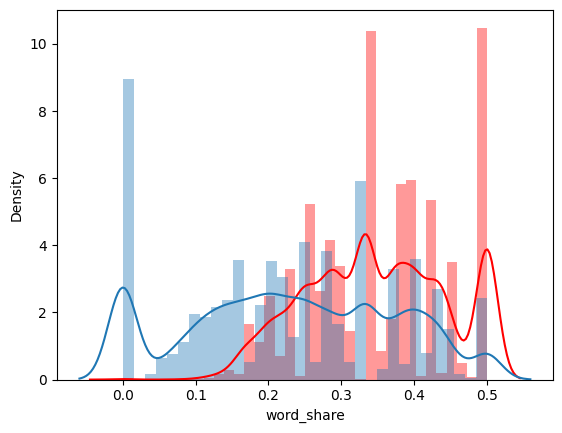

In [27]:
sns.distplot(train_df[train_df['is_duplicate'] == 1]['word_share'],label = 'duplicate',color = 'red')
sns.distplot(train_df[train_df['is_duplicate'] == 0]['word_share'],label = 'not duplicate')
plt.show()

In [28]:
train_df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'char_len_q1', 'char_len_q2', 'num_words_q1', 'num_words_q2',
       'common_words', 'total_words_row', 'word_share'],
      dtype='object')

In [29]:
words_less2_q1 = train_df[train_df['num_words_q1']<2]['id'].values
words_less2_q2 = train_df[train_df['num_words_q2']<2]['id'].values
train_df = train_df[~train_df['id'].isin(words_less2_q1)]
train_df = train_df[~train_df['id'].isin(words_less2_q2)]

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(max_features=3000)
q1 = tf.fit_transform(train_df['question1']).toarray()
q2 = tf.transform(train_df['question2']).toarray()
new_q1 = pd.DataFrame(q1,index = train_df.index)
new_q2 = pd.DataFrame(q2,index = train_df.index)

In [31]:
new_q1.shape,new_q2.shape

((29224, 3000), (29224, 3000))

In [32]:
temp_df = pd.concat([new_q1,new_q2],axis = 1)
temp_df.shape

(29224, 6000)

In [33]:
fts_int = [column for column in train_df.columns if train_df[column].dtype == "int64"]

In [34]:
fts_int.remove('id')
fts_int.remove('qid1')
fts_int.remove('qid2')
fts_int.remove('is_duplicate')

In [35]:
for fts in fts_int:
  temp_df[fts] = train_df[fts]

In [36]:
temp_df['is_duplicate'] = train_df['is_duplicate']

In [37]:
temp_df.shape

(29224, 6007)

In [38]:
from sklearn.model_selection import train_test_split as tts
X_train,X_test,y_train,y_test = tts(temp_df.iloc[:,:-1],temp_df.iloc[:,-1],train_size=0.8,random_state = 5)

In [39]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

In [40]:
from sklearn.metrics import recall_score,accuracy_score

In [41]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [42]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train,y_train)
pred1 = rf.predict(X_test)
print('acc: ',accuracy_score(y_test,pred1))
print('recall: ',recall_score(y_test,pred1))

acc:  0.7623609923011121
recall:  0.5387067395264117


In [43]:
xgb = XGBClassifier()
xgb.fit(X_train.values,y_train.values)
pred2 = xgb.predict(X_test.values)
print('acc: ',accuracy_score(y_test,pred2))
print('recall: ',recall_score(y_test,pred2))

acc:  0.7524379811804961
recall:  0.5833333333333334


In [44]:
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
pred3 = mnb.predict(X_test)
print('acc: ',accuracy_score(y_test,pred3))
print('recall: ',recall_score(y_test,pred3))

acc:  0.7377245508982035
recall:  0.5883424408014571


In [45]:
from sklearn.naive_bayes import GaussianNB,BernoulliNB
gnb = GaussianNB()
gnb.fit(X_train,y_train)
pred4 = gnb.predict(X_test)
print('acc: ',accuracy_score(y_test,pred4))
print('recall: ',recall_score(y_test,pred4))

acc:  0.5757057313943541
recall:  0.7955373406193078


In [46]:
bnb = BernoulliNB()
bnb.fit(X_train,y_train)
pred5 = bnb.predict(X_test)
print('acc: ',accuracy_score(y_test,pred5))
print('recall: ',recall_score(y_test,pred5))

acc:  0.7055603079555175
recall:  0.6024590163934426


In [47]:
train_df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'char_len_q1', 'char_len_q2', 'num_words_q1', 'num_words_q2',
       'common_words', 'total_words_row', 'word_share'],
      dtype='object')

In [48]:
train_df['cwc_max'] = train_df.apply(lambda row: row['common_words'] / max(row['num_words_q1'], row['num_words_q2']), axis=1)
train_df['cwc_min'] = train_df.apply(lambda row: row['common_words'] /min(row['num_words_q1'], row['num_words_q2']), axis=1)

In [54]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators=[('rf',rf),('gnb',gnb)],voting='soft')
voting.fit(X_train,y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(n_estimators=50)),
                             ('gnb', GaussianNB())],
                 voting='soft')

In [55]:
pred6 = voting.predict(X_test)
print('acc: ',accuracy_score(y_test,pred6))
print('recall: ',recall_score(y_test,pred6))

acc:  0.5803250641573995
recall:  0.7950819672131147


In [59]:
estimators=estimators=[('rf',rf),('gnb',gnb)]
final_estimator=RandomForestClassifier()

from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(estimators=estimators,final_estimator=final_estimator)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(recall_score(y_test,y_pred))

0.7572284003421728
0.6020036429872495


In [60]:
import pickle
pickle.dump(clf,open('model.pkl','wb'))
pickle.dump(tf,open('tfidf.pkl','wb'))